### Importing Necessary Libraries

In [50]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.manifold import TSNE

## Data

The training data consists of $16000$ images along with their labels.

In [3]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]
labels

id                        images  label
0          0      ./Data/train/train/0.tif      1
1          1      ./Data/train/train/1.tif     13
2          2      ./Data/train/train/2.tif     13
3          3      ./Data/train/train/3.tif     14
4          4      ./Data/train/train/4.tif      6
...      ...                           ...    ...
15995  15995  ./Data/train/train/15995.tif      2
15996  15996  ./Data/train/train/15996.tif     15
15997  15997  ./Data/train/train/15997.tif      3
15998  15998  ./Data/train/train/15998.tif      9
15999  15999  ./Data/train/train/15999.tif      9

[16000 rows x 3 columns]

The labels are ranging from $0-15$ for the following mentioned document types.

In [4]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})
label_names

labels                   names
0        0                  letter
1        1                    form
2        2                   email
3        3             handwritten
4        4           advertisement
5        5       scientific report
6        6  scientific publication
7        7           specification
8        8             file folder
9        9            news article
10      10                  budget
11      11                 invoice
12      12            presentation
13      13           questionnaire
14      14                  resume
15      15                    memo

There is no class imbalance in the training dataset and each class is well represented with $\sim 1000$ images per class label.

In [5]:
pd.value_counts(labels['label'])

8     1059
6     1044
0     1032
12    1020
5     1012
11    1011
13    1007
9     1000
3      993
14     992
15     988
10     974
1      969
2      968
4      966
7      965
Name: label, dtype: int64

Let's take a look at the document images for each class to get an idea of what sort of documents and their images we are dealing with.

Metal device set to: Apple M1 Max


2022-09-11 16:37:51.883648: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-11 16:37:51.883753: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


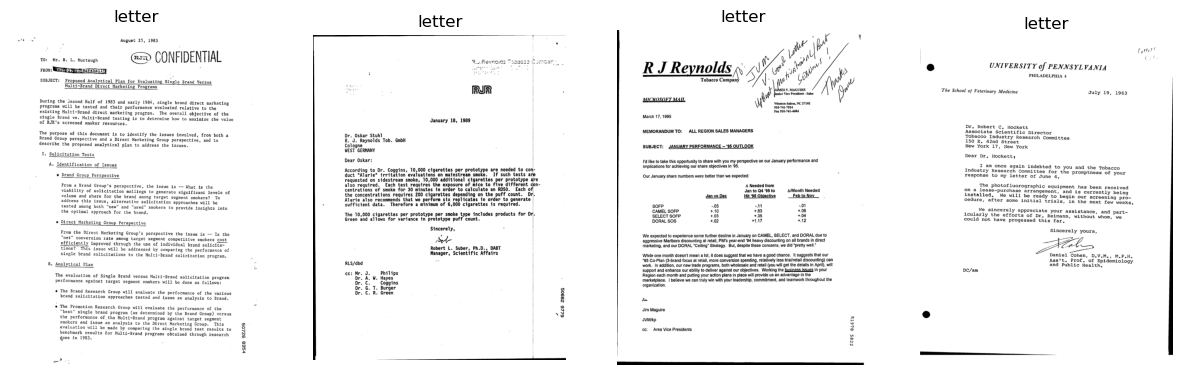

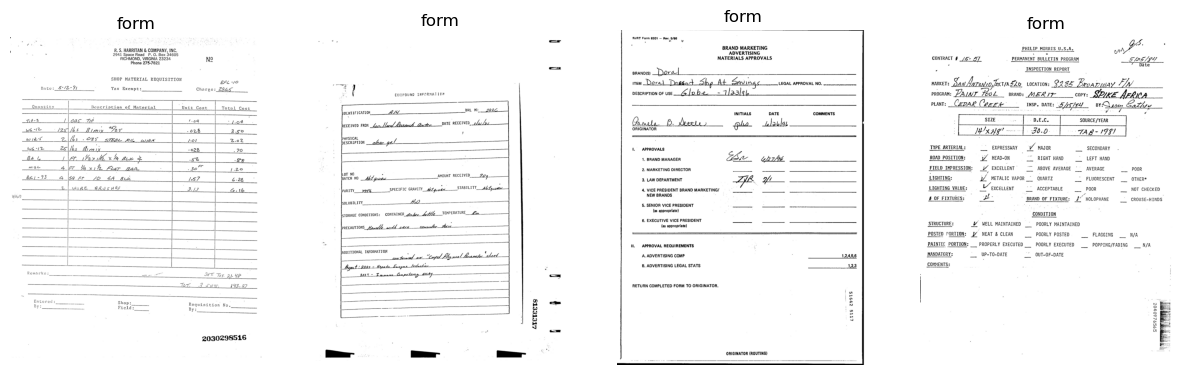

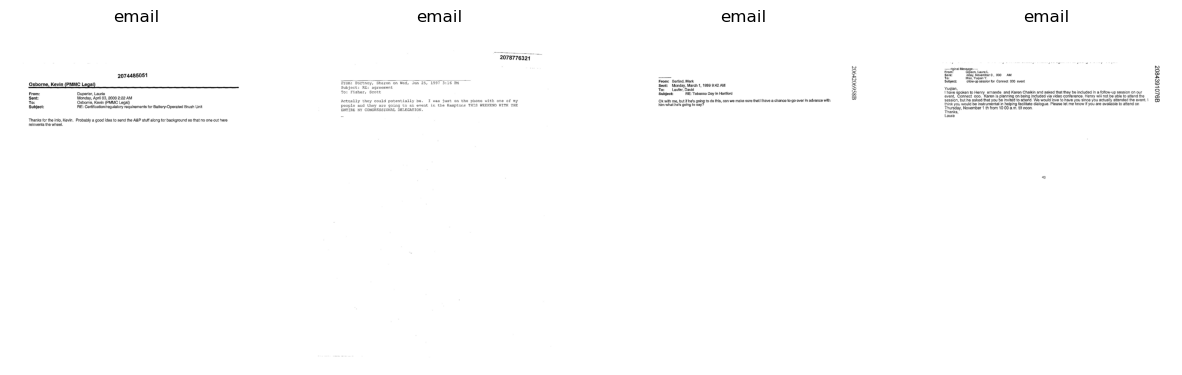

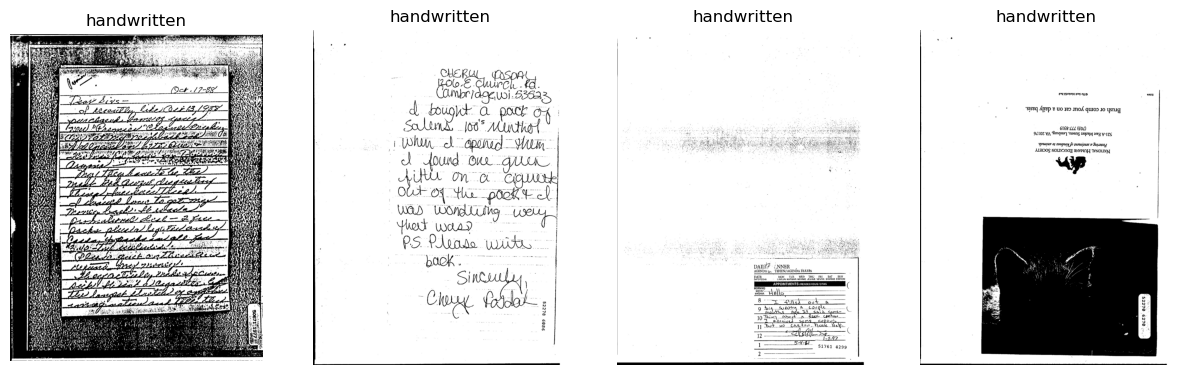

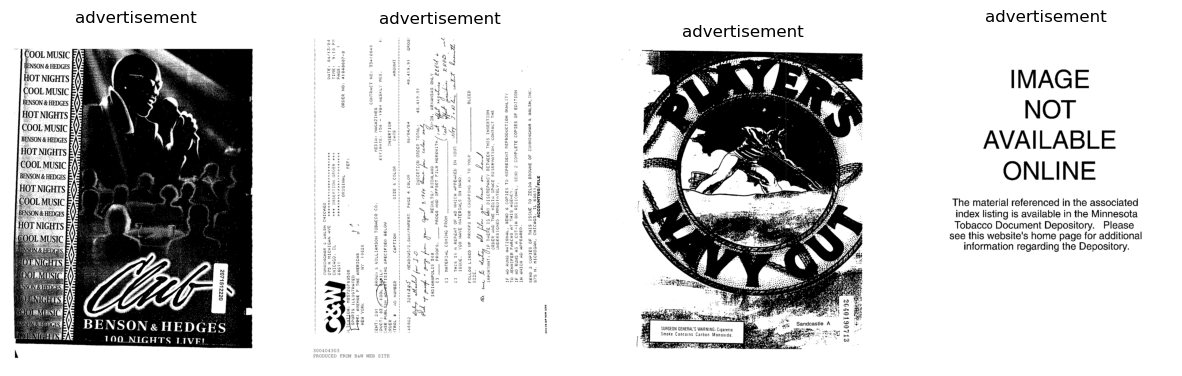

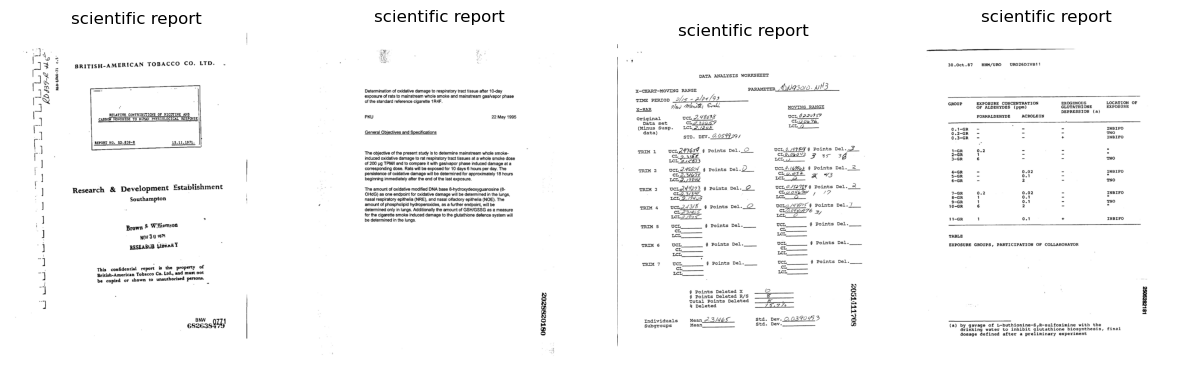

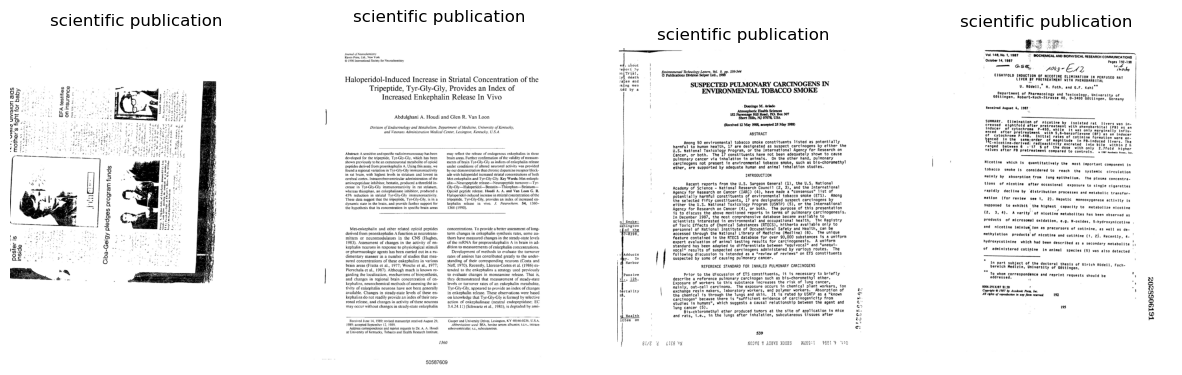

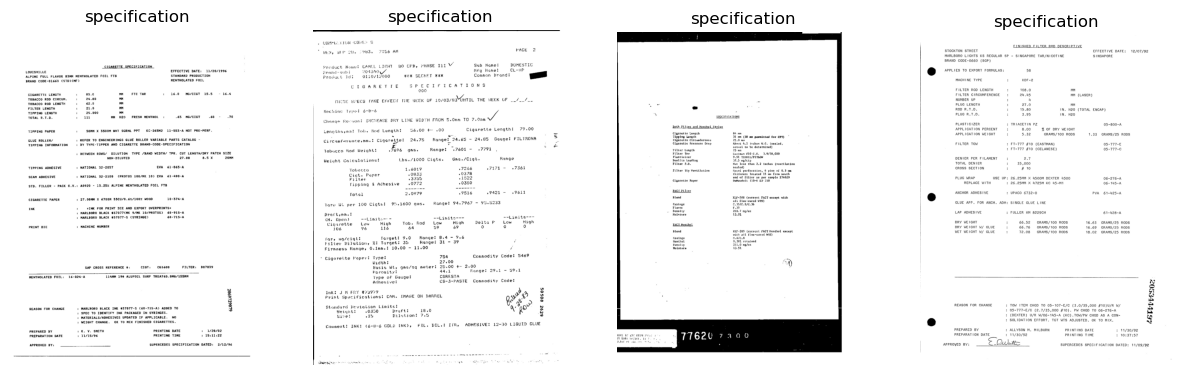

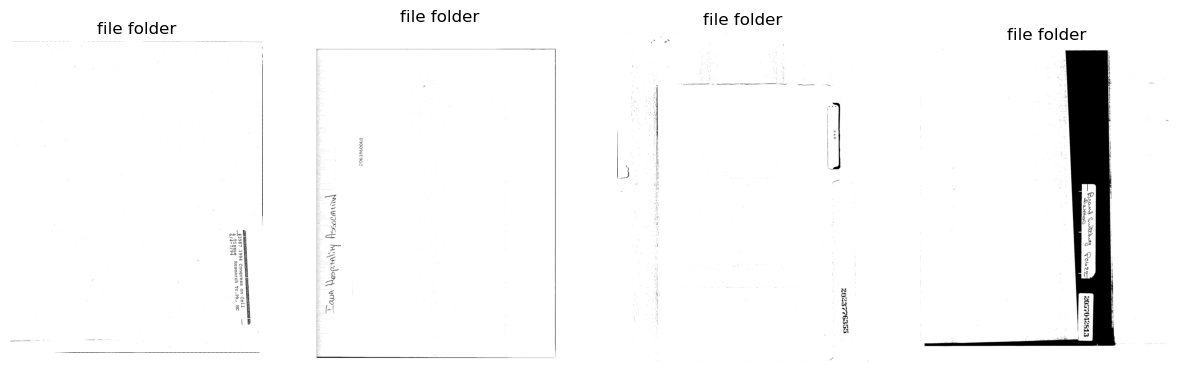

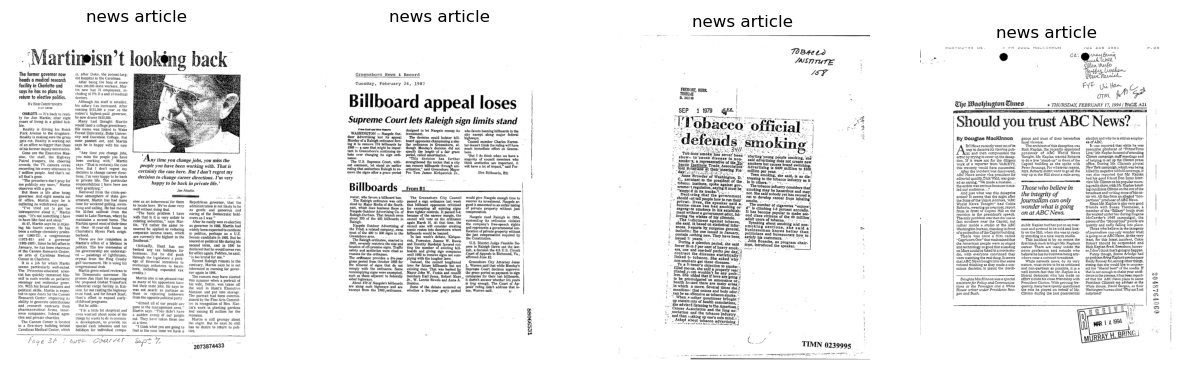

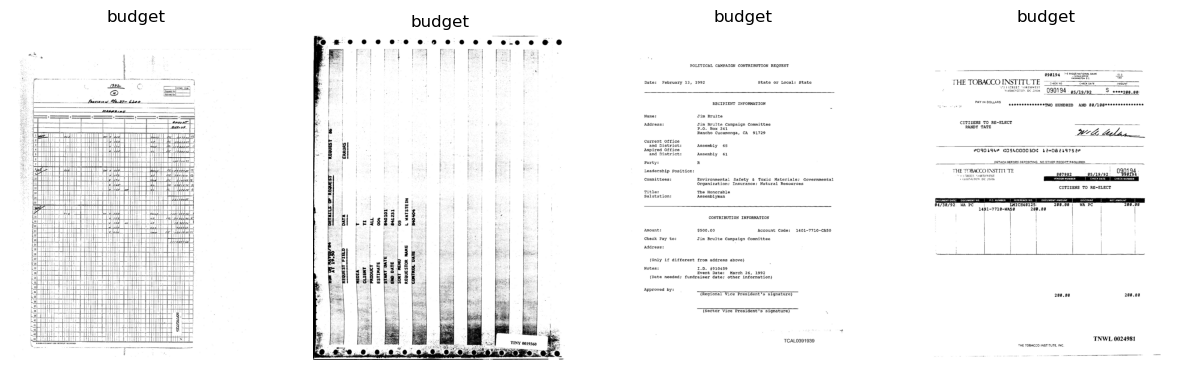

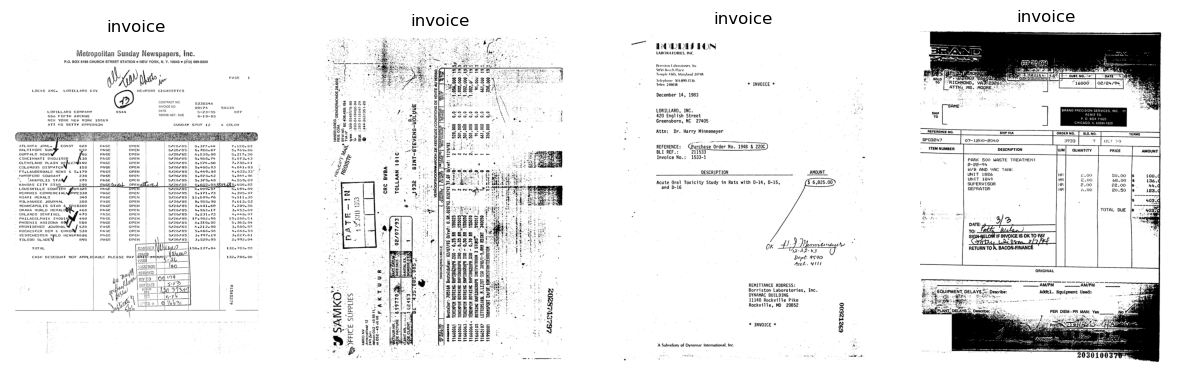

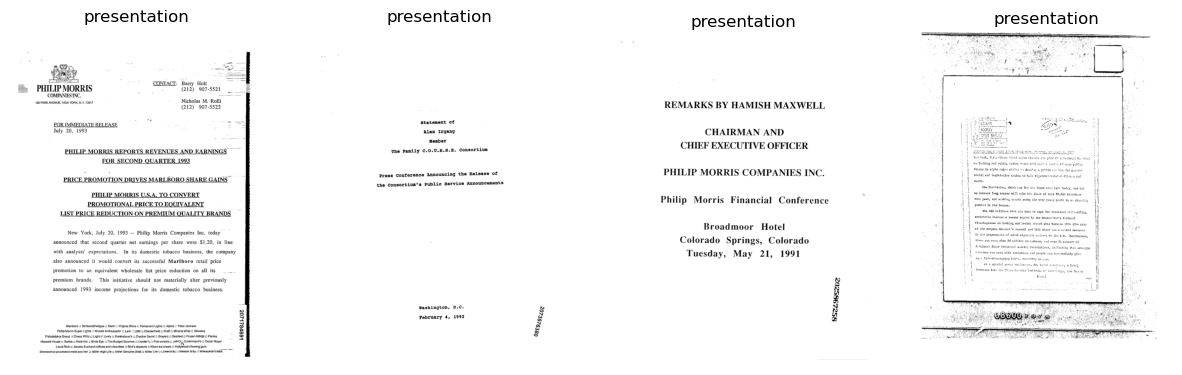

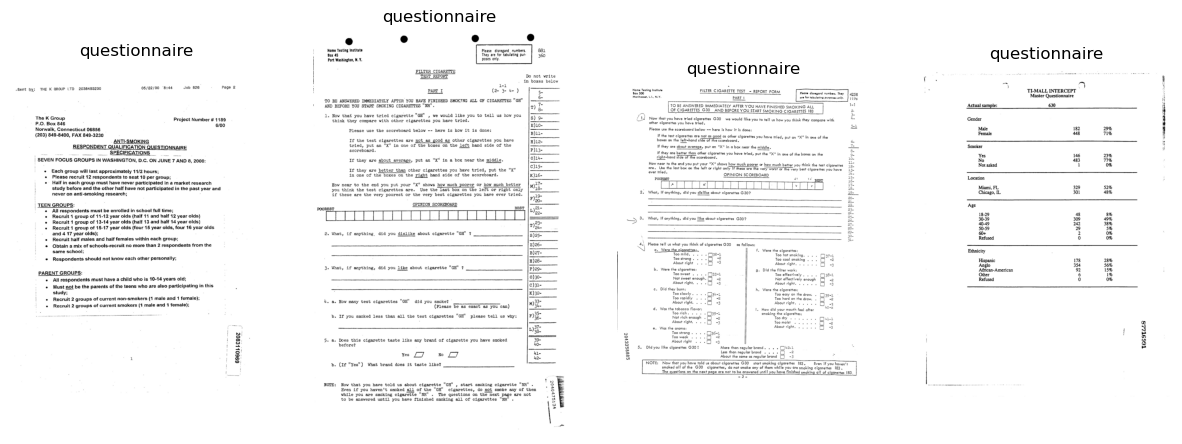

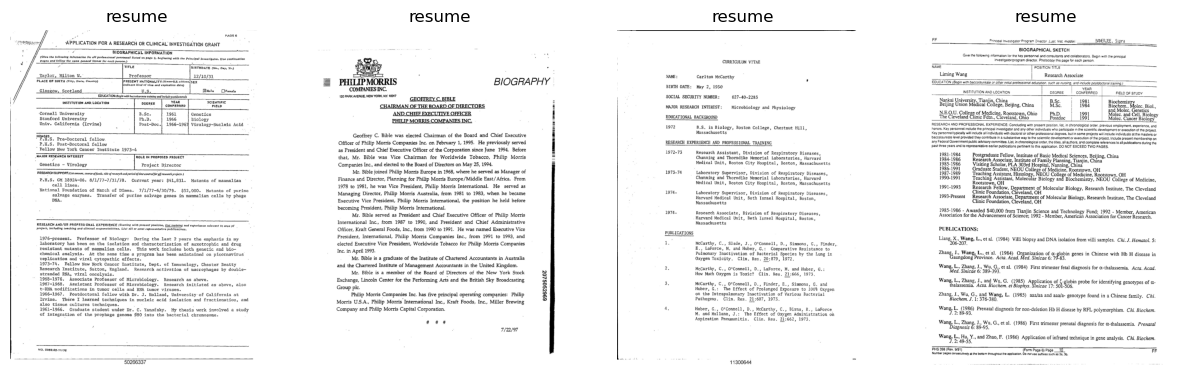

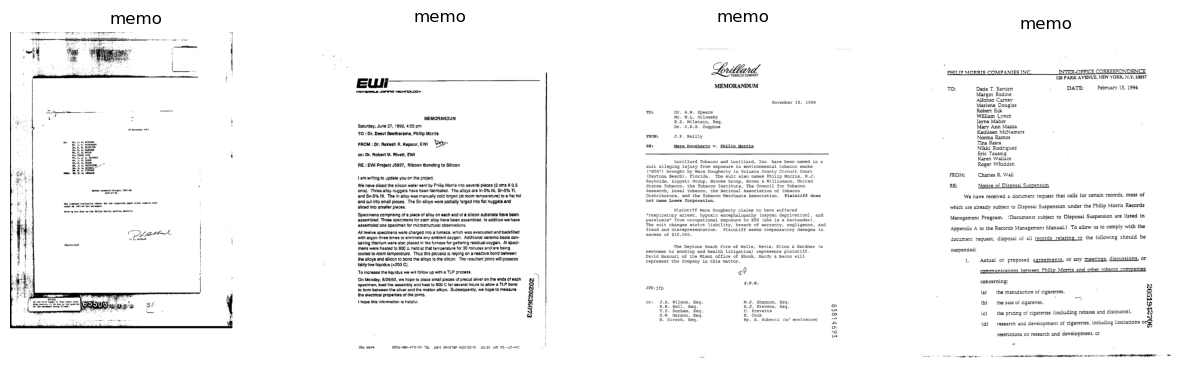

In [6]:
for i in range(len(class_labels)):
    fig, ax = plt.subplots(1, 4, figsize=(15, 30))
    imgs = [tf.cast(img_to_array(load_img(name)), dtype=tf.uint8) for name in list(labels[labels.label == i][:4]['images'])]
    m = 0
    for k in range(4):
        ax[k].imshow(imgs[m])
        ax[k].axis('off')
        ax[k].set_title(class_names[i])
        m += 1

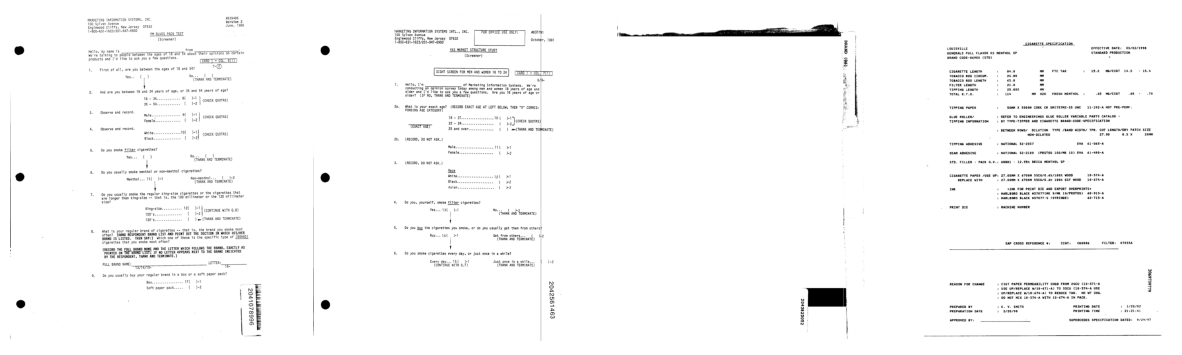

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(15, 30))
imgs = [tf.cast(img_to_array(load_img('./Data/validation/validation/'+name)), dtype=tf.uint8) for name in os.listdir('./Data/validation/validation')[:4]]
m = 0
for k in range(4):
    ax[k].imshow(imgs[m])
    ax[k].axis('off')
    m += 1

## Data Preparation

Since, there is a lot of image data instead of using the whole data at once in a tensor form, we would be using a data generator to prevent memory issues.

In [8]:
heights = [img.shape[0] for img in imgs]
widths = [img.shape[1] for img in imgs]
print("")
print("Mean Image Height:", np.mean(heights))
print("Mean Image Width:", np.mean(widths))
print("Min Image Height:", np.min(heights))
print("Min Image Width:", np.min(widths))


Mean Image Height: 1000.0
Mean Image Width: 770.5
Min Image Height: 1000
Min Image Width: 754


Observing the average image heights and widths, it is observed that setting image height to $1000$ and image width to $750$ is reseonable for training the model.

In [9]:
BATCH_SIZE = 40
INPUT_SHAPE = (800, 600) # Full Image
INPUT_HDR_SHAPE = INPUT_FTR_SHAPE = (250, 600)
INPUT_BDL_SHAPE = INPUT_BDR_SHAPE = (300, 300)

Since, the Keras' own data generator does not support TIFF images, we resort to writing our own custom data generator. It can also be leveraged to put custom image pre-processing or multi-input or output in the data processing pipeline.

In [10]:
class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col, batch_size, input_size=(800, 600), shuffle=True):
        self.df = df.copy() # DataFrame consisting image paths of inputs and the labels for the outputs
        self.X_col = X_col # Input column, specifying image path, in the DataFrame
        self.y_col = y_col # Output column, specifying corresponding label, in the DataFrame
        self.batch_size = batch_size # Batch Size
        self.input_size = input_size # Input Image size
        self.shuffle = shuffle # Shuffle Data after each epoch
        self.n = len(self.df) # length of the entire data
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path):
        img_arr = img_to_array(load_img(path))
        # some other pre-processing / data-augmentation goes here
        img_arr = tf.image.resize(img_arr, self.input_size)
        img_hdr, img_bdl, img_bdr, img_ftr = img_arr[:250], img_arr[250:-250, :300], img_arr[250:-250, -300:], img_arr[-250:]
        return [img_hdr/255.0, img_bdl/255.0, img_bdr/255.0, img_ftr/255.0, img_arr/255.0]
    
    def __get_data(self, batches):
        batch_paths = batches[self.X_col]
        batch_labels = batches[self.y_col]
        X_batch_4 = [self.__get_input(path) for path in batch_paths]
        X_batch = tf.cast([img[0] for img in X_batch_4], dtype=tf.float32), tf.cast([img[1] for img in X_batch_4], dtype=tf.float32), tf.cast([img[2] for img in X_batch_4], dtype=tf.float32), tf.cast([img[3] for img in X_batch_4], dtype=tf.float32), tf.cast([img[4] for img in X_batch_4], dtype=tf.float32)
        y_batch = tf.cast(batch_labels, dtype=tf.float32)
        return X_batch, y_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [11]:
train_generator = ImageDataGenerator(
    df=labels,
    X_col='images',
    y_col='label',
    batch_size=BATCH_SIZE,
    input_size=INPUT_SHAPE,
    shuffle=False
)

Below shows one batch from the ImageDataGenerator.

In [12]:
batch = next(iter(train_generator))
print('*** Batch Overview ***')
print('Number of Inputs:', len(batch[0]))
print('Input Image Header Tensor Shape:', batch[0][0].shape)
print('Input Image Body(L) Tensor Shape:', batch[0][1].shape)
print('Input Image Body(R) Tensor Shape:', batch[0][2].shape)
print('Input Image Footer Tensor Shape:', batch[0][3].shape)
print('Input Image Full Tensor Shape:', batch[0][4].shape)
print('Output Label Tensor Shape:', batch[1].shape)

*** Batch Overview ***
Number of Inputs: 5
Input Image Header Tensor Shape: (40, 250, 600, 3)
Input Image Body(L) Tensor Shape: (40, 300, 300, 3)
Input Image Body(R) Tensor Shape: (40, 300, 300, 3)
Input Image Footer Tensor Shape: (40, 250, 600, 3)
Input Image Full Tensor Shape: (40, 800, 600, 3)
Output Label Tensor Shape: (40,)


Each row below shows the $4$ parts of the same image and the full image, where the first being the header, second being the body(left), third is body(right) and last one is footer and the full image.

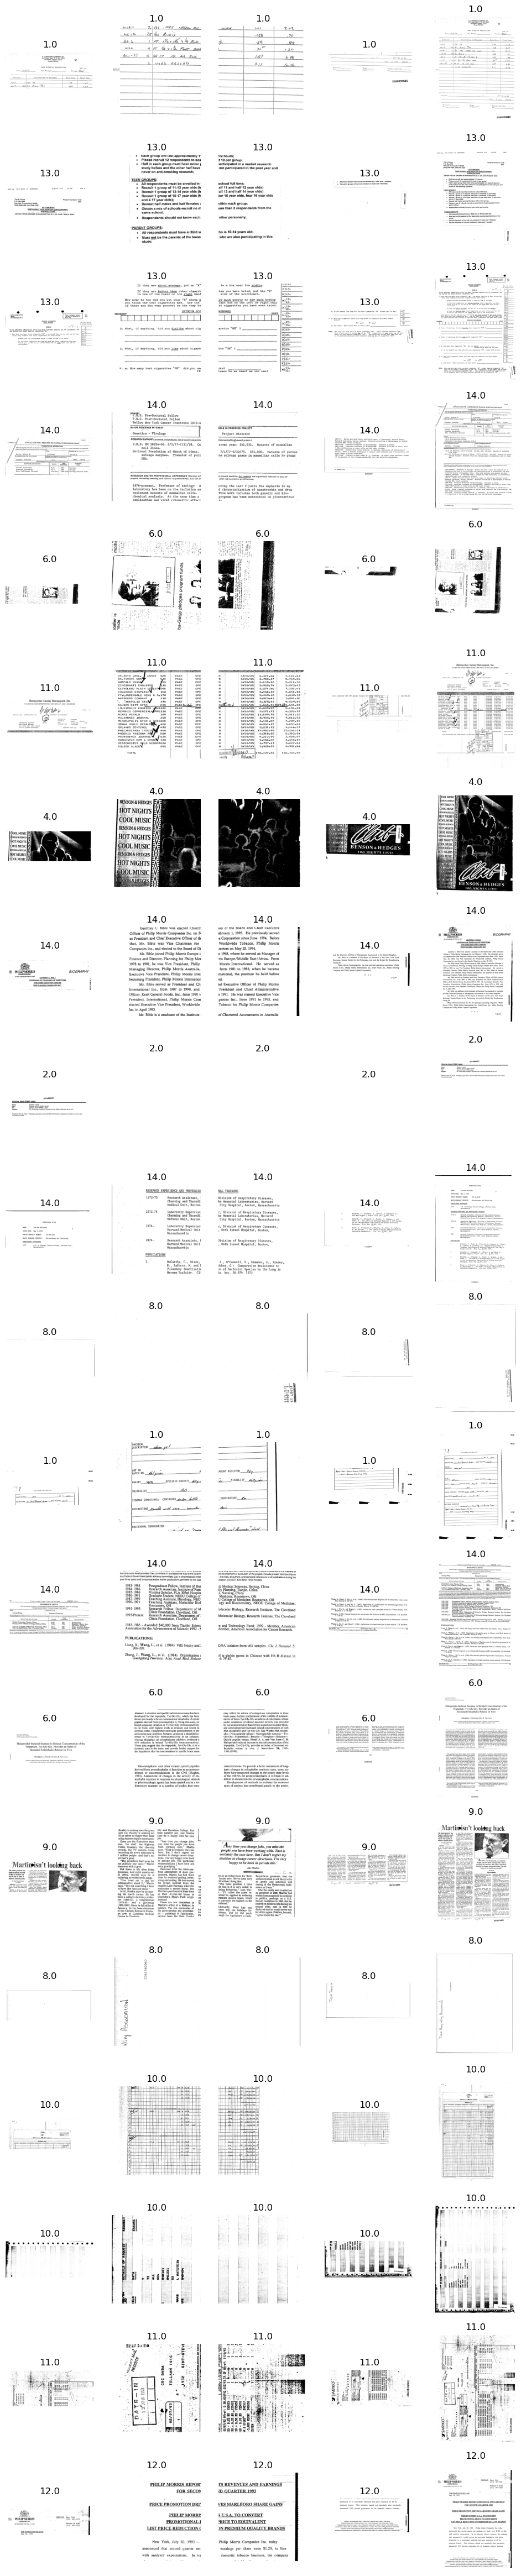

In [13]:
fig, ax = plt.subplots(BATCH_SIZE//2, 5, figsize=(12, 60))
imgs = batch[0]
labs = list(batch[1].numpy())
for j in range(BATCH_SIZE//2):
    for k in range(5):
        ax[j, k].imshow((imgs[k][j]*255).numpy().astype(np.uint8))
        ax[j, k].axis('off')
        ax[j, k].set_title(labs[j])

## Model Building

Now, a basic CNN-based model will be put to place. It will utilize the visual features only to classify the documents. Later we will be building much more better models considering other structures and multi-modality of the images and distinctive features.

- EfficientNetV2L

The EfficientNetV2L is a large model and since, we are not pre-training the entire model, we will just fine-tune it with two extra layers. So, to fasten training we precompute the output of the EfficientNetV2L model and use this for training the added Dense Layers for Fine-Tuning.

In [27]:
# Uncomment if you want to train again commented as too much RAM is used
# model_effnet = EfficientNetV2L(include_top=False, weights='imagenet')
# model_effnet.trainable = False

In [28]:
# inputs = [Input(shape=(*INPUT_HDR_SHAPE, 3)), Input(shape=(*INPUT_BDL_SHAPE, 3)), Input(shape=(*INPUT_BDR_SHAPE, 3)), Input(shape=(*INPUT_FTR_SHAPE, 3)), Input(shape=(*INPUT_SHAPE, 3))]
# outputs = [model_effnet(inp) for inp in inputs]
# outputs = [GlobalAvgPool2D()(out) for out in outputs]
# model = tf.keras.Model(inputs, outputs, name='EfficientNet-4Piece')

In [39]:
model.summary()

Model: "EfficientNet-4Piece"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 250, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_28 (InputLayer)          [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_29 (InputLayer)          [(None, 300, 300, 3  0           []                               
                                )]                                              

In [29]:
# precompute_EffNet_output = 0
# for idx in range(len(labels)//1600):
#     train_generator_precompute = ImageDataGenerator(
#         df=labels[idx*1600:(idx+1)*1600],
#         X_col='images',
#         y_col='label',
#         batch_size=BATCH_SIZE,
#         input_size=INPUT_SHAPE,
#         shuffle=False
#     )
#     precompute_EffNet_output = model.predict(train_generator_precompute)
#     np.save(f'./Data/EffNet-4P-train-precompute/train_data_precomp-{idx}.npy', precompute_EffNet_output)

2022-09-11 16:55:49.310080: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-11 16:55:58.212716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 311s 8s/step


In [40]:
# fine_tune_data = np.concatenate([np.transpose(np.load(f'./Data/EffNet-4P-train-precompute/train_data_precomp-{idx}.npy'), (1,0,2)) for idx in range(10)])
# np.save(f'./Data/EffNet-4P-train-precompute/whole_train_data_precomp.npy', fine_tune_data)
# fine_tune_data.shape

(16000, 5, 1280)

The EfficientNetV2L gives a 3D output per image with $1280$ channels which are collapsed using GlobalAveragePooling2D and we get a 1280 representation vector per 4 parts of the image and full image ($4+1=5$) which will be used to train the later extra layers of our model.

In [55]:
fine_tune_data = np.load('./Data/EffNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data.shape

(16000, 5, 1280)

In [56]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

## Fine-Tuning Models

The fine-tuning part of our model.

In [57]:
def ftmodel():
    inputs = Input(shape=(5, 1280))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(top_dropout_rate, name='top_dropout_final')(x)
    outputs = Dense(16, activation='softmax', name='pred')(x)

    model1 = tf.keras.Model(inputs, outputs, name='EfficientNet-FineTune')
    return model1

In [58]:
model1 = ftmodel()
model1.summary()

Model: "EfficientNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 5, 1280)]         0         
                                                                 
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 batch_normalization_5 (Batc  (None, 6400)             25600     
 hNormalization)                                                 
                                                                 
 top_dropout_1 (Dropout)     (None, 6400)              0         
                                                                 
 top_dense_1 (Dense)         (None, 1024)              6554624   
                                                                 
 top_dropout_2 (Dropout)     (None, 1024)              0         
                                             

### Model Training

The fine-tuning will be done on the EfficientNet's $1280D$ representation vectors.

In [59]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [61]:
EPOCHS = 2000
checkpoint_filepaths = ['./Models/EfficientNet-4P/auto-EffNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [49]:
history = model1.fit(fine_tune_data, fine_tune_labels, epochs=EPOCHS, batch_size=1600, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/EfficientNet-4P/hdr-model-weights")
model1.load_weights('./Models/EfficientNet-4P/hdr-model-weights')

Epoch 1/1000


2022-09-11 18:53:16.984258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 2s 25ms/step - loss: 3.3292 - accuracy: 0.1961
Epoch 2/1000
20/20 [==============================] - 1s 29ms/step - loss: 2.7525 - accuracy: 0.3043
Epoch 3/1000
20/20 [==============================] - 0s 13ms/step - loss: 2.5311 - accuracy: 0.3431
Epoch 4/1000
20/20 [==============================] - 0s 13ms/step - loss: 2.4344 - accuracy: 0.3690
Epoch 5/1000
20/20 [==============================] - 0s 13ms/step - loss: 2.3707 - accuracy: 0.3840
Epoch 6/1000
20/20 [==============================] - 0s 20ms/step - loss: 2.2994 - accuracy: 0.3969
Epoch 7/1000
20/20 [==============================] - 0s 12ms/step - loss: 2.2760 - accuracy: 0.4042
Epoch 8/1000
20/20 [==============================] - 0s 12ms/step - loss: 2.2413 - accuracy: 0.4166
Epoch 9/1000
20/20 [==============================] - 0s 13ms/step - loss: 2.2326 - accuracy: 0.4147
Epoch 10/1000
20/20 [==============================] - 0s 14ms/step - loss: 2.2104 - accuracy: 0.4244
Ep

20/20 [==============================] - 0s 10ms/step - loss: 1.8937 - accuracy: 0.4986
Epoch 82/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.8939 - accuracy: 0.4967
Epoch 83/1000
20/20 [==============================] - 0s 14ms/step - loss: 1.8877 - accuracy: 0.5014
Epoch 84/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.8926 - accuracy: 0.4999
Epoch 85/1000
20/20 [==============================] - 0s 13ms/step - loss: 1.8816 - accuracy: 0.4966
Epoch 86/1000
20/20 [==============================] - 0s 11ms/step - loss: 1.8882 - accuracy: 0.5011
Epoch 87/1000
20/20 [==============================] - 0s 14ms/step - loss: 1.8780 - accuracy: 0.5026
Epoch 88/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.8907 - accuracy: 0.5002
Epoch 89/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.8805 - accuracy: 0.5048
Epoch 90/1000
20/20 [==============================] - 0s 22ms/step - loss: 1.8803 - accuracy: 0.49

20/20 [==============================] - 0s 14ms/step - loss: 1.7909 - accuracy: 0.5213
Epoch 162/1000
20/20 [==============================] - 0s 12ms/step - loss: 1.7908 - accuracy: 0.5133
Epoch 163/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.7935 - accuracy: 0.5120
Epoch 164/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.7967 - accuracy: 0.5121
Epoch 165/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.7929 - accuracy: 0.5184
Epoch 166/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.7943 - accuracy: 0.5124
Epoch 167/1000
20/20 [==============================] - 0s 13ms/step - loss: 1.7860 - accuracy: 0.5185
Epoch 168/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.7925 - accuracy: 0.5134
Epoch 169/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.7993 - accuracy: 0.5121
Epoch 170/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.7921 - accura

20/20 [==============================] - 0s 8ms/step - loss: 1.7308 - accuracy: 0.5227
Epoch 242/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.7391 - accuracy: 0.5178
Epoch 243/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.7334 - accuracy: 0.5250
Epoch 244/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.7402 - accuracy: 0.5220
Epoch 245/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.7432 - accuracy: 0.5207
Epoch 246/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.7432 - accuracy: 0.5172
Epoch 247/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.7364 - accuracy: 0.5199
Epoch 248/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.7306 - accuracy: 0.5223
Epoch 249/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.7360 - accuracy: 0.5234
Epoch 250/1000
20/20 [==============================] - 0s 13ms/step - loss: 1.7279 - accuracy: 

20/20 [==============================] - 0s 9ms/step - loss: 1.7027 - accuracy: 0.5221
Epoch 322/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6969 - accuracy: 0.5298
Epoch 323/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.7051 - accuracy: 0.5210
Epoch 324/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.7136 - accuracy: 0.5264
Epoch 325/1000
20/20 [==============================] - 0s 11ms/step - loss: 1.7023 - accuracy: 0.5244
Epoch 326/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6986 - accuracy: 0.5255
Epoch 327/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6974 - accuracy: 0.5193
Epoch 328/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6909 - accuracy: 0.5286
Epoch 329/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6897 - accuracy: 0.5301
Epoch 330/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.7028 - accuracy: 0

20/20 [==============================] - 0s 13ms/step - loss: 1.6692 - accuracy: 0.5257
Epoch 402/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6687 - accuracy: 0.5307
Epoch 403/1000
20/20 [==============================] - 0s 14ms/step - loss: 1.6622 - accuracy: 0.5317
Epoch 404/1000
20/20 [==============================] - 0s 8ms/step - loss: 1.6631 - accuracy: 0.5264
Epoch 405/1000
20/20 [==============================] - 0s 15ms/step - loss: 1.6606 - accuracy: 0.5293
Epoch 406/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6656 - accuracy: 0.5292
Epoch 407/1000
20/20 [==============================] - 0s 13ms/step - loss: 1.6474 - accuracy: 0.5317
Epoch 408/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6552 - accuracy: 0.5304
Epoch 409/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.6713 - accuracy: 0.5273
Epoch 410/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6729 - accurac

20/20 [==============================] - 0s 9ms/step - loss: 1.6618 - accuracy: 0.5255
Epoch 482/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.6415 - accuracy: 0.5299
Epoch 483/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6526 - accuracy: 0.5312
Epoch 484/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.6392 - accuracy: 0.5294
Epoch 485/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6382 - accuracy: 0.5378
Epoch 486/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6403 - accuracy: 0.5270
Epoch 487/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.6384 - accuracy: 0.5349
Epoch 488/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6416 - accuracy: 0.5354
Epoch 489/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6426 - accuracy: 0.5304
Epoch 490/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.6403 - accuracy

20/20 [==============================] - 0s 10ms/step - loss: 1.6251 - accuracy: 0.5336
Epoch 562/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.6330 - accuracy: 0.5298
Epoch 563/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.6329 - accuracy: 0.5298
Epoch 564/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6267 - accuracy: 0.5369
Epoch 565/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.6246 - accuracy: 0.5345
Epoch 566/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6183 - accuracy: 0.5391
Epoch 567/1000
20/20 [==============================] - 0s 13ms/step - loss: 1.6148 - accuracy: 0.5354
Epoch 568/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6285 - accuracy: 0.5333
Epoch 569/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6266 - accuracy: 0.5325
Epoch 570/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.6370 - accura

20/20 [==============================] - 0s 11ms/step - loss: 1.6130 - accuracy: 0.5356
Epoch 642/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6090 - accuracy: 0.5330
Epoch 643/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6035 - accuracy: 0.5379
Epoch 644/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.6102 - accuracy: 0.5354
Epoch 645/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6131 - accuracy: 0.5356
Epoch 646/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.6082 - accuracy: 0.5363
Epoch 647/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.6036 - accuracy: 0.5349
Epoch 648/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6109 - accuracy: 0.5329
Epoch 649/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.6168 - accuracy: 0.5345
Epoch 650/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6145 - accurac

20/20 [==============================] - 0s 9ms/step - loss: 1.5951 - accuracy: 0.5396
Epoch 722/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.5975 - accuracy: 0.5383
Epoch 723/1000
20/20 [==============================] - 0s 11ms/step - loss: 1.5986 - accuracy: 0.5352
Epoch 724/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.6009 - accuracy: 0.5372
Epoch 725/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6042 - accuracy: 0.5341
Epoch 726/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6016 - accuracy: 0.5341
Epoch 727/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6004 - accuracy: 0.5343
Epoch 728/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5981 - accuracy: 0.5318
Epoch 729/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5962 - accuracy: 0.5374
Epoch 730/1000
20/20 [==============================] - 0s 11ms/step - loss: 1.6062 - accuracy

20/20 [==============================] - 0s 9ms/step - loss: 1.5811 - accuracy: 0.5394
Epoch 802/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5898 - accuracy: 0.5354
Epoch 803/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5887 - accuracy: 0.5365
Epoch 804/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.5909 - accuracy: 0.5321
Epoch 805/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5885 - accuracy: 0.5392
Epoch 806/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5796 - accuracy: 0.5420
Epoch 807/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.6007 - accuracy: 0.5337
Epoch 808/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.5933 - accuracy: 0.5366
Epoch 809/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5838 - accuracy: 0.5349
Epoch 810/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5888 - accuracy: 

20/20 [==============================] - 0s 9ms/step - loss: 1.5770 - accuracy: 0.5394
Epoch 882/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5740 - accuracy: 0.5393
Epoch 883/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5872 - accuracy: 0.5331
Epoch 884/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5842 - accuracy: 0.5358
Epoch 885/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.5896 - accuracy: 0.5409
Epoch 886/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5890 - accuracy: 0.5369
Epoch 887/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5959 - accuracy: 0.5384
Epoch 888/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5754 - accuracy: 0.5388
Epoch 889/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5811 - accuracy: 0.5418
Epoch 890/1000
20/20 [==============================] - 0s 10ms/step - loss: 1.5704 - accuracy: 

20/20 [==============================] - 0s 10ms/step - loss: 1.5820 - accuracy: 0.5374
Epoch 962/1000
20/20 [==============================] - 0s 13ms/step - loss: 1.5647 - accuracy: 0.5393
Epoch 963/1000
20/20 [==============================] - 0s 8ms/step - loss: 1.5706 - accuracy: 0.5373
Epoch 964/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5671 - accuracy: 0.5437
Epoch 965/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5797 - accuracy: 0.5393
Epoch 966/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5772 - accuracy: 0.5383
Epoch 967/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5804 - accuracy: 0.5426
Epoch 968/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5850 - accuracy: 0.5370
Epoch 969/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5778 - accuracy: 0.5412
Epoch 970/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.5840 - accuracy: 